# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
azdias_copy = azdias.copy()
feat_info_copy = feat_info.copy()

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)


(891221, 85)
(85, 4)


In [5]:
#first 5 rows of azdias dataset
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
#first 5 rows of feat_info dataset
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
azdias.shape

(891221, 85)

In [8]:
# data types for azdias
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [9]:
# data types for feat_info
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# accessing missing data from azdias dataset
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [11]:
column_names = azdias.columns
column_names

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
missing_unk = feat_info['missing_or_unknown']

In [13]:
# Function convert missing values to NaN
def convert_missing_to_nan(df):
    for i, item in zip(range(len(df)), df.iteritems()):
        missing_unk = feat_info['missing_or_unknown'][i]
        missing_unk = missing_unk[1:-1].split(',')
        column_name = item[0]
        if missing_unk != ['']:
            miss = [x if x in ['X', 'XX'] else int(x) for x in missing_unk]
            
            df[column_names] = df[column_names].replace(miss, np.nan)
    return df, missing_unk

In [14]:
#apply function to convert missing values
azdias, missing_unk = convert_missing_to_nan(azdias)

In [15]:
#checking table for replacement of missing values
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,NaN,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,NaN,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,NaN,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,NaN,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [16]:
## getting null value counts
azdias.isnull().sum().head()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

In [17]:
# Drop rows where all values are null
azdias.dropna(how='all').shape

(891221, 85)

In [18]:
#view table after drop all
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,NaN,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,NaN,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,NaN,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,NaN,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
chk_missing_col_vals = azdias.isnull().sum()
chk_missing_col_vals


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP           65468
GREEN_AVANTGARDE         715996
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN      110698
LP_LEBENSPHASE_GROB      143510
LP_FAMILIE_FEIN           88940
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN           148092
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    141734
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [20]:
# only columns with missing values
missing_col_vals = chk_missing_col_vals[chk_missing_col_vals > 0]
missing_col_vals

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP           65468
GREEN_AVANTGARDE         715996
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN      110698
LP_LEBENSPHASE_GROB      143510
LP_FAMILIE_FEIN           88940
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN           148092
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    141734
RETOURTYP_BK_S             4854
SHOPPER_TYP              238778
SOHO_KZ                  884333
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 333084
ANZ_PERSONEN             107782
ANZ_TITEL                888041
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008           624675
ANZ_HAUSHALTE_AKTIV      128613
ANZ_HH_TITEL             867286
GEBAEUDETYP               93148
                          ...  
OST_WEST

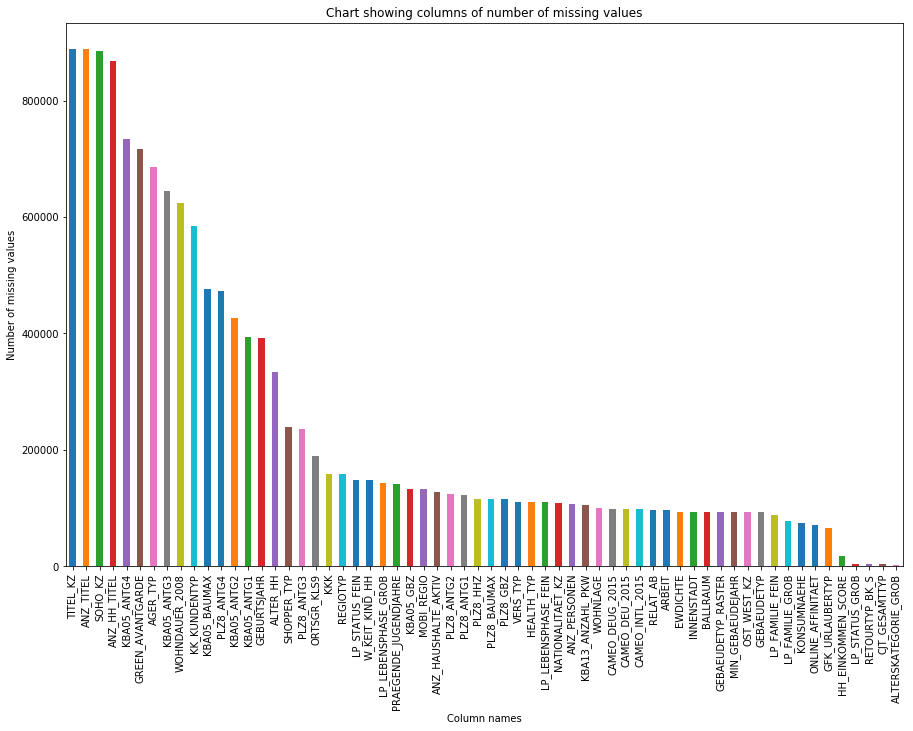

In [21]:
# visualization of missing values

#sort missing vals col for chart for easier reading
missing_col_vals.sort_values(inplace=True, ascending=False)  

#create bar chart of missing values
missing_col_vals.plot.bar(figsize=(15, 10))
plt.xlabel('Column names')
plt.ylabel('Number of missing values')
plt.title('Chart showing columns of number of missing values')
plt.show()

In [22]:
# Investigate patterns in the amount of missing data in each column.
# percentage of missing values sorted for easier reading of data

pct_missing_vals = missing_col_vals.sort_values()/len(azdias) * 100
pct_missing_vals

ALTERSKATEGORIE_GROB      0.323264
LP_STATUS_GROB            0.544646
CJT_GESAMTTYP             0.544646
RETOURTYP_BK_S            0.544646
HH_EINKOMMEN_SCORE        2.058749
GFK_URLAUBERTYP           7.345877
ONLINE_AFFINITAET         7.918350
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           9.979567
GEBAEUDETYP              10.451729
OST_WEST_KZ              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
RELAT_AB                 10.926022
ARBEIT                   10.926022
CAMEO_INTL_2015          11.147852
CAMEO_DEU_2015           11.147852
CAMEO_DEUG_2015          11.147852
WOHNLAGE                 11.231558
KBA13_ANZAHL_PKW         11.879096
ANZ_PERSONEN             12.093746
NATIONALITAET_KZ         12.153551
LP_LEBENSPHASE_FEIN      12.420937
HEALTH_TYP               12.476816
VERS_TYP            

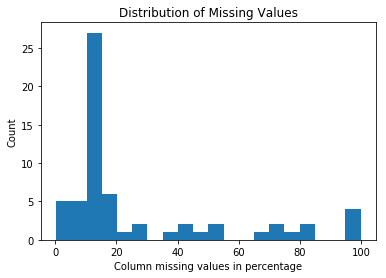

In [23]:
#visualization of distribution of pct_missing_vals

plt.hist(pct_missing_vals, bins=20)
plt.xlabel('Column missing values in percentage')
plt.ylabel('Count')
plt.title('Distribution of Missing Values')

plt.show()

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#Determine mean and percentage of values of data
# 75 % of the missing data is around the 35%, of the all values above 35%will be removed as outliers as they do not conform to the majority of the data set 
pct_missing_vals_mean = pct_missing_vals.mean()

pct_missing_vals.describe()


count    62.000000
mean     26.929385
std      28.334798
min       0.323264
25%      10.518154
50%      13.073637
75%      34.728479
max      99.757636
dtype: float64

In [25]:
#identify columns with percentage of missing vals greater than 35% as outliers
pct_greater_35 = []
for col in azdias.columns:
    if (azdias[col].isnull().sum()/azdias.shape[0]) * 100 > 35:
        pct_greater_35.append(col)
        
pct_greater_35

['AGER_TYP',
 'GEBURTSJAHR',
 'GREEN_AVANTGARDE',
 'SOHO_KZ',
 'TITEL_KZ',
 'ALTER_HH',
 'ANZ_TITEL',
 'KK_KUNDENTYP',
 'WOHNDAUER_2008',
 'ANZ_HH_TITEL',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'PLZ8_ANTG4']

In [26]:
#Remvoe outlier columns from dataset

azdias = azdias.drop(pct_greater_35, axis=1)


In [27]:
#columns removed and columns remaining

print(f'{len(pct_greater_35)} columns removed')
print(f'{azdias.shape[1]} columns remaining')


16 columns removed
69 columns remaining


In [28]:
#making copy of changes
azdias_copy1 = azdias.copy()

#### Discussion 1.1.2: Assess Missing Data in Each Column
The missing data for this dataset consisted of 62 columns that had missing data.  Of those the column with the most missing data was 'TITEL_KZ' which contained 99.76% of missing data, followed closely by 'ANZ_TITEL' and 'SOHO_KZ' both with percentages in the 99% range.  Using the describe method on the missing data it can be seen that roughly 75% of the data is made up of 35% or lower missing data percentage.  Based on this a threshold of 35% was set and columns containing greater than 35% were dropped from the dataset as outliers.  This consisted of 16 columns being removed which were identified as 'AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP', 'WOHNDAUER_2008', 'ANZ_HH_TITEL', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'PLZ8_ANTG4'. All of these columns contained missing data greater than 35%.   Based on visualizations of the missing values it appears that there is sharp increase in missing data after the approximate 35% range, which could later create issues with analysis.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [29]:
# How much data is missing in each row of the dataset?
ck_missing_row_vals = azdias.isnull().sum(axis=1)
ck_missing_row_vals

0         34
1          0
2          0
3          9
4          0
5          1
6          0
7          2
8          0
9          1
10         0
11        38
12         3
13         4
14        38
15         7
16         7
17        38
18         3
19         1
20         9
21         0
22         0
23         9
24        38
25         8
26        14
27         1
28         1
29         2
          ..
891191     0
891192     2
891193     0
891194     2
891195     1
891196     0
891197     1
891198     1
891199     0
891200     1
891201     0
891202     0
891203    11
891204     2
891205     1
891206     2
891207     0
891208     5
891209     2
891210     1
891211     1
891212     2
891213     1
891214     0
891215     0
891216     4
891217     4
891218     7
891219     4
891220     1
Length: 891221, dtype: int64

In [30]:
# simpliy output by not displaying rows with 0 missing values and ordering output
missing_row_vals = ck_missing_row_vals[ck_missing_row_vals > 0]
missing_row_vals.sort_values(inplace=True, ascending=False)
missing_row_vals

732775    43
643174    43
472919    42
547468    39
814046    39
826869    39
281305    39
469054    39
58254     39
212053    39
174378    39
80444     39
227757    39
451655    39
161480    39
141404    39
170081    39
392456    39
613253    39
15284     39
537799    39
15680     39
283772    38
283836    38
283849    38
566544    38
283794    38
283821    38
566468    38
566501    38
          ..
404271     1
404272     1
404275     1
404278     1
404280     1
404281     1
404290     1
404291     1
404232     1
404227     1
404158     1
404225     1
404160     1
404163     1
404164     1
404171     1
404173     1
404176     1
404179     1
404180     1
404195     1
404196     1
404197     1
404198     1
404199     1
404207     1
404211     1
404214     1
404216     1
891220     1
Length: 667009, dtype: int64

In [31]:
pct_missing_row_vals = missing_row_vals.sort_values()/azdias.shape[1]*100
pct_missing_row_vals

891220     1.449275
785498     1.449275
559385     1.449275
559324     1.449275
559335     1.449275
559381     1.449275
559380     1.449275
559379     1.449275
559376     1.449275
559374     1.449275
559373     1.449275
559368     1.449275
559365     1.449275
559266     1.449275
559361     1.449275
785481     1.449275
559354     1.449275
559351     1.449275
559349     1.449275
559345     1.449275
559339     1.449275
559337     1.449275
785491     1.449275
559504     1.449275
559507     1.449275
559508     1.449275
559694     1.449275
785480     1.449275
559275     1.449275
559279     1.449275
            ...    
870226    55.072464
111293    55.072464
670464    55.072464
670466    55.072464
670472    55.072464
111259    55.072464
111954    55.072464
111258    55.072464
212053    56.521739
58254     56.521739
469054    56.521739
547468    56.521739
826869    56.521739
814046    56.521739
174378    56.521739
281305    56.521739
80444     56.521739
537799    56.521739
451655    56.521739


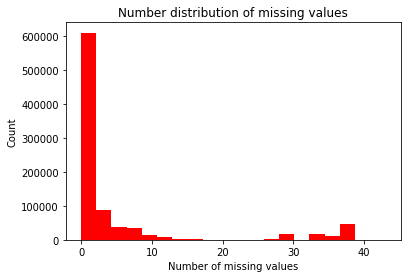

In [32]:
#histogram of missing row values
plt.hist(ck_missing_row_vals, bins=20, facecolor='r')
plt.xlabel('Number of missing values')
plt.ylabel('Count')
plt.title('Number distribution of missing values')
plt.show()

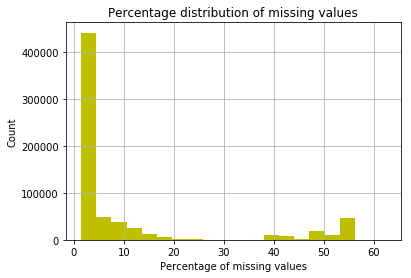

In [33]:
plt.hist(pct_missing_row_vals, bins=20, facecolor='y')
plt.xlabel('Percentage of missing values')
plt.ylabel('Count')
plt.title('Percentage distribution of missing values')
plt.grid(True)
plt.show()

In [34]:
missing_row_vals.describe()

count    667009.000000
mean          7.296371
std          11.519867
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max          43.000000
dtype: float64

In [35]:
pct_missing_row_vals.describe()

count    667009.000000
mean         10.574450
std          16.695460
min           1.449275
25%           1.449275
50%           2.898551
75%           8.695652
max          62.318841
dtype: float64

In [36]:
azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP',
       'ANZ_PERSONEN', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'ANZ_HAUSHALTE_AKTIV', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR',
       'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
       'CAMEO_INTL_2015', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
   

In [37]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
few_missing_vals = azdias[azdias.isnull().sum(axis=1) <= 20].reset_index(drop=True)
many_missing_vals = azdias[azdias.isnull().sum(axis=1) > 20].reset_index(drop=True)

In [38]:
few_missing_vals.index, many_missing_vals.index

(RangeIndex(start=0, stop=797892, step=1),
 RangeIndex(start=0, stop=93329, step=1))

In [39]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_chart_func(column):
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Many missing row values')
    sns.countplot(azdias.loc[many_missing_vals.index,column])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Few missing row values')
    sns.countplot(azdias.loc[~azdias.index.isin(few_missing_vals),column]);

    fig.suptitle(column)
    plt.show()

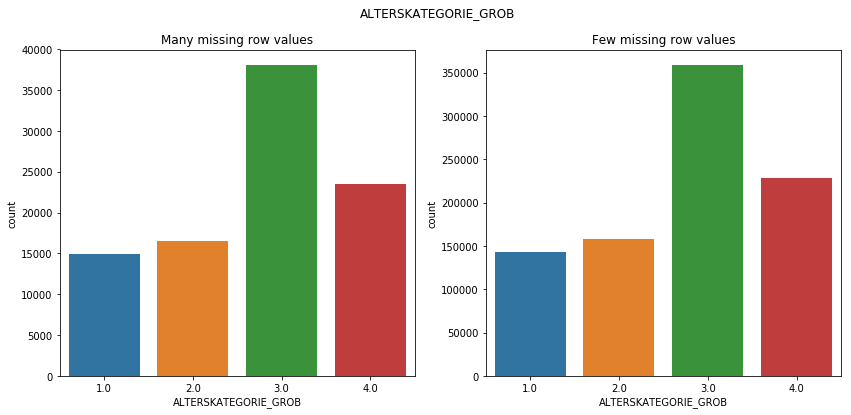

In [40]:
compare_chart_func('ALTERSKATEGORIE_GROB')

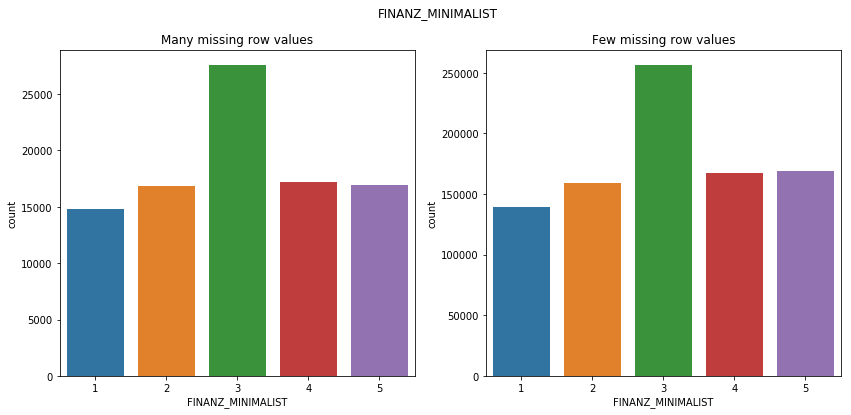

In [41]:
compare_chart_func('FINANZ_MINIMALIST')

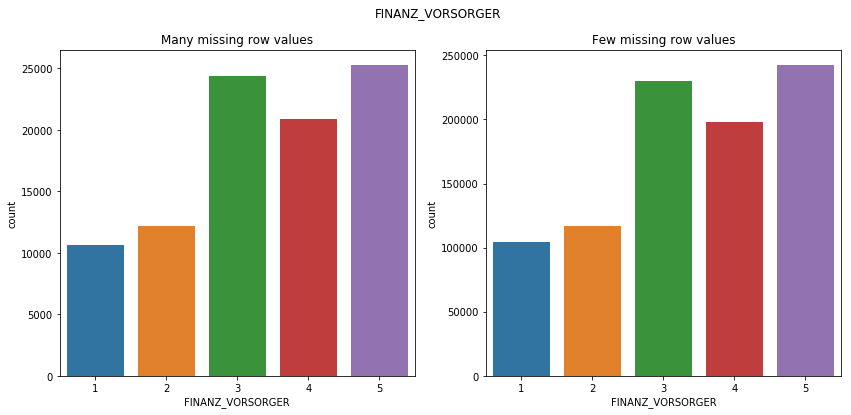

In [42]:
compare_chart_func('FINANZ_VORSORGER')

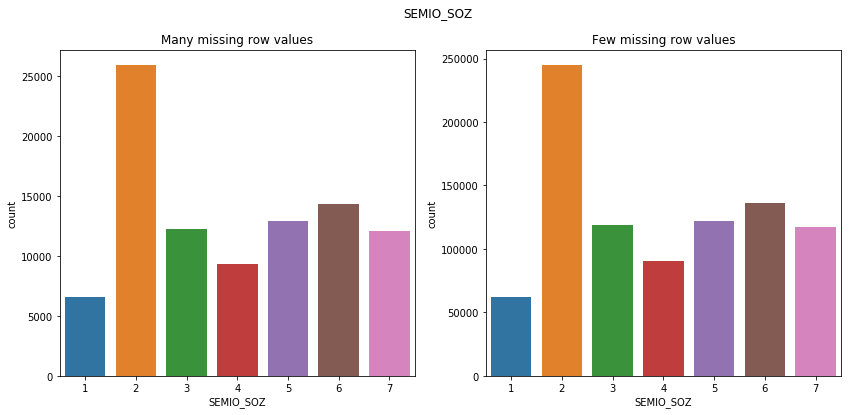

In [43]:
compare_chart_func('SEMIO_SOZ')

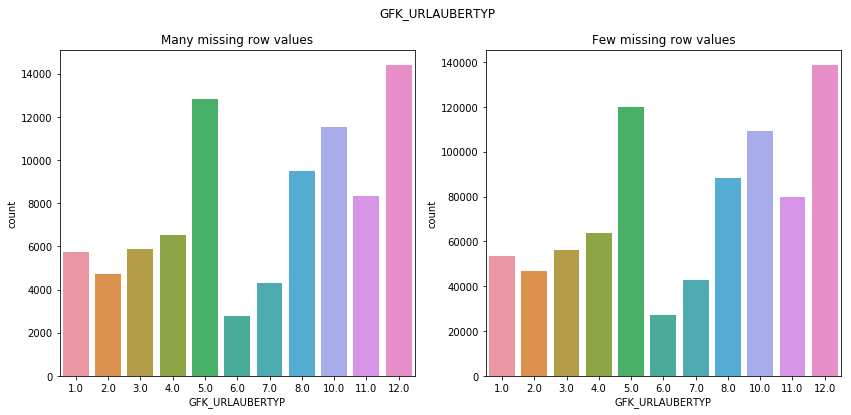

In [44]:
compare_chart_func('GFK_URLAUBERTYP')

In [45]:
len(many_missing_vals)

93329

In [46]:
azdias.shape[0]

891221

In [47]:
azdias_many_miss = azdias.iloc[many_missing_vals.index]
azdias = azdias[~azdias.index.isin(many_missing_vals.index)]
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
93329,3.0,1,2.0,5,1,5,1,1,2,5,...,521.0,2.0,3.0,1.0,5.0,4.0,1.0,1.0,4.0,1.0
93330,1.0,2,3.0,4,3,1,4,3,1,3,...,843.0,4.0,2.0,NaN,1.0,4.0,5.0,3.0,1.0,4.0
93331,4.0,1,2.0,5,1,5,1,2,2,2,...,428.0,4.0,2.0,1.0,1.0,3.0,4.0,1.0,5.0,1.0
93332,2.0,1,2.0,4,2,4,1,3,3,5,...,719.0,2.0,4.0,2.0,2.0,4.0,3.0,4.0,8.0,3.0
93333,4.0,2,2.0,2,1,5,1,2,5,2,...,853.0,3.0,1.0,1.0,1.0,4.0,5.0,3.0,4.0,2.0


In [48]:
azdias.shape

(797892, 69)

In [49]:
few_missing_vals.shape

(797892, 69)

In [50]:
azdias_copy2 = azdias.copy()
feat_info_copy1 = feat_info.copy()

#### Discussion 1.1.3: Assess Missing Data in Each Row
Observation of charts for comparison indicates that the rows with many missing values are not as significant as the rows with few missing row values under 20.  The threshold of less than or equal to 20 was chosen for this comparison.  As the amount of many_missing_row_values would not significantly impact further predictions they are removed from our dataset. 



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [51]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [52]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [53]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_cols = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
#selecting categorical columns in azdias
categorical_cols = [categorical_col for categorical_col in categorical_cols if categorical_col in azdias.columns]
categorical_cols

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [54]:
azdias[categorical_cols].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     11
LP_FAMILIE_FEIN     10
LP_FAMILIE_GROB      5
LP_STATUS_FEIN       9
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          3
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [55]:
# Re-encode categorical variable(s) to be kept in the analysis.
column_binary = []
column_multi = []
for col in categorical_cols:
    if azdias[col].nunique() > 2:
        column_multi.append(col)
    else:
        column_binary.append(col)


In [56]:
# list of binary columns
column_binary

['ANREDE_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [57]:
#binary cols and values
for col in column_binary:
    print(azdias[col].value_counts())

2    416400
1    381492
Name: ANREDE_KZ, dtype: int64
2.0    356795
1.0    341942
Name: VERS_TYP, dtype: int64
W    562704
O    152038
Name: OST_WEST_KZ, dtype: int64


In [58]:
#reencode OSTWESTKZ to binary variables
azdias['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace=True)

#azdias.loc[azdias['OST_WEST_KZ'] == 'O'] = 0
#azdias.loc[azdias['OST_WEST_KZ'] == 'W'] = 1

In [59]:
#checking for change of 'OST_WEST_KZ'
for col in column_binary:
    print(azdias[col].value_counts())

2    416400
1    381492
Name: ANREDE_KZ, dtype: int64
2.0    356795
1.0    341942
Name: VERS_TYP, dtype: int64
0.0    562704
1.0    152038
Name: OST_WEST_KZ, dtype: int64


In [60]:
# list of multi-level columns
column_multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [61]:
#dropping multi-level columns
azdias.drop(column_multi, axis=1, inplace=True)

In [62]:
azdias.shape[1]

56

#### Discussion 1.2.1: Re-Encode Categorical Features
I examined the remaining columns for categorical features to determine if they were either binary or multilevel columns. There were a total of 16 categorical columns that were addressed, 3 identified as binary and 13 as multilevel columns.  All multilevel columns were removed from the dataset.  Of the 3 binary columns,'ANREDE_KZ', 'VERS_TYP', 'OST_WEST_KZ', one column, 'OST_WEST_KZ', required reencoding of the variables where string letters 'W' and 'O' were transformed to numerical binary codeof 0 and 1.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [63]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# pulling sample of column

azdias[['PRAEGENDE_JUGENDJAHRE']].sample(15)

,PRAEGENDE_JUGENDJAHRE
565836,11.0
144427,14.0
619149,14.0
466277,8.0
597210,15.0
317262,NaN
484988,3.0
273905,1.0
861891,5.0
154695,NaN


In [64]:
# function to define decade
def decade(x):
    if x in (1,2):
        return 1
    elif x in (3, 4):
        return 2
    elif x in (5, 6, 7):
        return 3
    elif x in (8, 9):
        return 4
    elif x in (10, 11, 12, 13):
        return 5
    elif x in (14, 15):
        return 6

In [65]:
#function to define movement as binary variable 
def movement(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    elif x in (1,3,5,8,10,12,14):
        return 1

In [66]:
#assigning new colums to azdias and populating columns with functions
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(decade)
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(movement)

In [67]:
azdias['DECADE'].value_counts().sort_index()

1.0     25814
2.0     67872
3.0    104070
4.0    130554
5.0    135897
6.0    207223
Name: DECADE, dtype: int64

In [68]:
azdias['MOVEMENT'].value_counts().sort_index()

0.0    127120
1.0    544310
Name: MOVEMENT, dtype: int64

In [69]:
#dropping column PRAEGENDE_JUGENDJAHRE
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [70]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias[['CAMEO_INTL_2015']].sample(15)

,CAMEO_INTL_2015
343632,54
201085,51
556958,51
133930,34
837633,25
502662,52
389319,24
105637,NaN
648873,44
324646,14


In [71]:
# creating function to define wealth
def wealth(x):
    if x // 10 == 1:
        return 1
    elif x // 10 == 2:
        return 2
    elif x // 10 == 3:
        return 3
    elif x // 10 == 4:
        return 4
    elif x // 10 == 5:
        return 5

In [72]:
#create function to define lifestage
def lifestage(x):
    if x % 10 == 1:
        return 1
    elif x % 10 == 2:
        return 2
    elif x % 10 == 3:
        return 3
    elif x % 10 == 4:
        return 4
    elif x % 10 == 5:
        return 5

In [73]:
#checking data type of column after trying to run below code with apply function and received error
azdias['CAMEO_INTL_2015'].dtype

dtype('O')

In [74]:
#change dtype 'O' to numeric
azdias['CAMEO_INTL_2015'] = pd.to_numeric(azdias['CAMEO_INTL_2015'])

In [75]:
#creating columns for wealth and lifestage and then populating the columns with appropriate functions
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(wealth)
azdias['LIFESTAGE'] = azdias['CAMEO_INTL_2015'].apply(lifestage)

In [76]:
#checking column value counts
azdias['WEALTH'].value_counts().sort_index()

1.0    107117
2.0    171036
3.0     61162
4.0    170035
5.0    199801
Name: WEALTH, dtype: int64

In [77]:
#checking column value counts
azdias['LIFESTAGE'].value_counts().sort_index()

1.0    219091
2.0     69213
3.0    107223
4.0    208630
5.0    104994
Name: LIFESTAGE, dtype: int64

In [78]:
# dropping CAMEO_INTL_2015 column
azdias = azdias.drop('CAMEO_INTL_2015', axis=1) 

In [79]:
# checking data set to ensure all are inserted and dropped
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
93329,3.0,1,5,1,5,1,1,2,3.0,40.0,...,5.0,4.0,1.0,1.0,4.0,1.0,2.0,0.0,5.0,1.0
93330,1.0,2,4,3,1,4,3,1,3.0,10.0,...,1.0,4.0,5.0,3.0,1.0,4.0,6.0,1.0,2.0,4.0
93331,4.0,1,5,1,5,1,2,2,2.0,NaN,...,1.0,3.0,4.0,1.0,5.0,1.0,1.0,0.0,1.0,4.0
93332,2.0,1,4,2,4,1,3,3,NaN,32.0,...,2.0,4.0,3.0,4.0,8.0,3.0,4.0,1.0,2.0,5.0
93333,4.0,2,2,1,5,1,2,5,2.0,NaN,...,1.0,4.0,5.0,3.0,4.0,2.0,3.0,0.0,4.0,1.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

For the PRAEGENDE_JUGENDJAHRE column, this column was broken up into 2 new columns consisting of DECADE and MOVEMENT.  DECADE was encoded with interval values 1-6, where 1:40's, 2:50's, 3:60's, 4:70's, 5:80's 6:90's.  The results indicated the following values for each internval: 1.0 = 25814, 2.0 = 67872, 3.0 = 104070, 4.0 = 130554, 5.0 = 135897, 6.0 = 207223. Also a column for movement was created and populated by a function resulting in 0.0 (Avantgarde) = 127120 and 1.0 (Mainstream) = 544310.  Following the creation and population of the new columns the old column was dropped.
For the CAMEO_INTL_2015 column, this column was broken up into two seperate columns consisting of WEALTH and LIFESTAGE.  WEALTH was found to have an Ordinal data type and was thus changed to a numeric data type prior to encoding the new columns.  WEALTH was encoded into variables 1 thru 5, where 1 = Wealthy, 2 = Prosperous, 3 = Comfortable, 4 = Less Affluent, 5 = Poorer The results indicated the following value counts for each: 1.0 = 107117, 2.0 = 171036, 3.0 = 61162, 4.0 = 170035, 5.0 = 199801.  The last column created was the LIFESTAGE column this was conducted in the same manner with the following results: 1.0 = 219091, 2.0 = 69213, 3.0 = 107223, 4.0 = 208630, 5.0 = 104994.  Upon completion of creating new columns and populating the columns the orginal column PRAEGENDE_JUGENDJAHRE was dropped from the azdias table.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [80]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
np.unique(azdias.dtypes.values)


array([dtype('int64'), dtype('float64')], dtype=object)

In [81]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias.loc[:, azdias.dtypes == 'O']

""
93329
93330
93331
93332
93333
93334
93335
93336
93337
93338


In [82]:
#drop CAMEO_DEU_2015 / already done
#azdias = azdias.drop('CAMEO_DEU_2015', axis=1)

In [83]:
#checking column was dropped.  previous col. count was 71
azdias.shape

(797892, 58)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [84]:
'''def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for i, item in zip(range(len(df)), df.iteritems()):
        missing_unk = feat_info['missing_or_unknown'][i]
        missing_unk = missing_unk[1:-1].split(',')
        column_name = item[0]
        if missing_unk != ['']:
            miss = [x if x in ['X', 'XX'] else int(x) for x in missing_unk]
            
            df[column_names] = df[column_names].replace(miss, np.nan)
    
    # remove selected columns and rows, ...
    chk_missing_col_vals = df.isnull().sum()
    missing_col_vals = chk_missing_col_vals[chk_missing_col_vals > 0]
    pct_missing_vals = missing_col_vals.sort_values()/len(df) * 100
    pct_greater_35 = []
    for col in df.columns:
        if (df[col].isnull().sum()/df.shape[0]) * 100 > 35:
            pct_greater_35.append(col)

    df = df.drop(pct_greater_35, axis=1)
    
    few_missing_vals = df[df.isnull().sum(axis=1) <= 20].reset_index(drop=True)
    many_missing_vals = df[df.isnull().sum(axis=1) > 20].reset_index(drop=True)
    df_many_miss = df.iloc[many_missing_vals.index]
    df = df[~df.index.isin(many_missing_vals.index)]
    
    # select, re-encode, and engineer column values.
    categorical_cols = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
    categorical_cols = [categorical_col for categorical_col in categorical_cols if categorical_col in df.columns]
    # Re-encode categorical variable(s) to be kept in the analysis.
    column_binary = []
    column_multi = []
    for col in categorical_cols:
        if df[col].nunique() > 2:
            column_multi.append(col)
        else:
            column_binary.append(col)
            
    #Re-encode OST_WEST_KZ to binary variables	Binary variables
    df['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace=True)
    
    df.drop(column_multi, axis=1, inplace=True)
    
    # assigning Decade and Movement columns
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    
    #dropping PRAEGENDE_JUDENDJAHRE col
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    # CAMEO_INTL_2015
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(wealth)
    df['LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(lifestage)
    df = df.drop('CAMEO_INTL_2015', axis=1)#.reset_index(inplace=True) 
    
    col_list = df.columns
    
    # impute NaN 
    imputer = Imputer(strategy='mean', axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df, columns=column_list)
    
    # Return the cleaned dataframe.
    
    return df
    
    '''

'def clean_data(df):\n    """\n    Perform feature trimming, re-encoding, and engineering for demographics\n    data\n    \n    INPUT: Demographics DataFrame\n    OUTPUT: Trimmed and cleaned demographics DataFrame\n    """\n    \n    # Put in code here to execute all main cleaning steps:\n    # convert missing value codes into NaNs, ...\n    \n    for i, item in zip(range(len(df)), df.iteritems()):\n        missing_unk = feat_info[\'missing_or_unknown\'][i]\n        missing_unk = missing_unk[1:-1].split(\',\')\n        column_name = item[0]\n        if missing_unk != [\'\']:\n            miss = [x if x in [\'X\', \'XX\'] else int(x) for x in missing_unk]\n            \n            df[column_names] = df[column_names].replace(miss, np.nan)\n    \n    # remove selected columns and rows, ...\n    chk_missing_col_vals = df.isnull().sum()\n    missing_col_vals = chk_missing_col_vals[chk_missing_col_vals > 0]\n    pct_missing_vals = missing_col_vals.sort_values()/len(df) * 100\n    pct_greate

In [85]:
def clean_data(df):
    #PREPROCESSING - columns
    column_names = df.columns

    #convert missing to NAN)
    for i, item in zip(range(len(df)), df.iteritems()):
            missing_unk = feat_info['missing_or_unknown'][i]
            missing_unk = missing_unk[1:-1].split(',')
            column_name = item[0]
            if missing_unk != ['']:
                miss = [x if x in ['X', 'XX'] else int(x) for x in missing_unk]

                df[column_names] = df[column_names].replace(miss, np.nan)

    df.dropna(how='all').shape

    chk_missing_col_vals = df.isnull().sum()
    missing_col_vals = chk_missing_col_vals[chk_missing_col_vals > 0]
    missing_col_vals.sort_values(inplace=True, ascending=False)  
    pct_missing_vals = missing_col_vals.sort_values()/len(df) * 100

    pct_greater_35 = []
    for col in df.columns:
        if (df[col].isnull().sum()/df.shape[0]) * 100 > 35:
            pct_greater_35.append(col)

    df = df.drop(pct_greater_35, axis=1)

    #PREPROCESSING – rows
    ck_missing_row_vals = df.isnull().sum(axis=1)
    missing_row_vals = ck_missing_row_vals[ck_missing_row_vals > 0]
    missing_row_vals.sort_values(inplace=True, ascending=False)
    pct_missing_row_vals = missing_row_vals.sort_values()/df.shape[1]*100
    few_missing_vals = df[df.isnull().sum(axis=1) <= 20].reset_index(drop=True)
    many_missing_vals = df[df.isnull().sum(axis=1) > 20].reset_index(drop=True)
    df_many_miss = df.iloc[many_missing_vals.index]
    df = df[~df.index.isin(many_missing_vals.index)]

    #SELECT and RE-Encode Features
    #reencode categorical features
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    categorical_cols = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
    #selecting categorical columns in df
    categorical_cols = [categorical_col for categorical_col in categorical_cols if categorical_col in df.columns]

    # Re-encode categorical variable(s) to be kept in the analysis.
    column_binary = []
    column_multi = []
    for col in categorical_cols:
        if df[col].nunique() > 2:
            column_multi.append(col)
        else:
            column_binary.append(col)

    #reencode OSTWESTKZ to binary variables
    df['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace=True)

    #dropping multi-level columns
    df.drop(column_multi, axis=1, inplace=True)

    #engineer mixed type features
    #assigning new colums to df and populating columns with functions
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(movement)

    #df['DECADE'].value_counts().sort_index()
    #df['MOVEMENT'].value_counts().sort_index()

    #dropping column PRAEGENDE_JUGENDJAHRE
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

    #change dtype 'O' to numeric
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])

    #creating columns for wealth and lifestage and then populating the columns with appropriate functions
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(wealth)
    df['LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(lifestage)

    #checking column value counts
    #df['WEALTH'].value_counts().sort_index()
    #df['LIFESTAGE'].value_counts().sort_index()

    # dropping CAMEO_INTL_2015 column
    df = df.drop('CAMEO_INTL_2015', axis=1)

    column_list = df.columns

    # If you've not yet cleaned the dataset of all NaN values, then investigate and
    # do that now.
    imputer = Imputer(strategy='mean', axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df, columns=column_list)

    return df

In [86]:
azdias_copy3 = azdias.copy()

In [87]:
azdias_copy3.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
93329,3.0,1,5,1,5,1,1,2,3.0,40.0,...,5.0,4.0,1.0,1.0,4.0,1.0,2.0,0.0,5.0,1.0
93330,1.0,2,4,3,1,4,3,1,3.0,10.0,...,1.0,4.0,5.0,3.0,1.0,4.0,6.0,1.0,2.0,4.0
93331,4.0,1,5,1,5,1,2,2,2.0,NaN,...,1.0,3.0,4.0,1.0,5.0,1.0,1.0,0.0,1.0,4.0
93332,2.0,1,4,2,4,1,3,3,NaN,32.0,...,2.0,4.0,3.0,4.0,8.0,3.0,4.0,1.0,2.0,5.0
93333,4.0,2,2,1,5,1,2,5,2.0,NaN,...,1.0,4.0,5.0,3.0,4.0,2.0,3.0,0.0,4.0,1.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [88]:
#create work copy
from sklearn.preprocessing import Imputer

azdias_work = azdias_copy3.copy()

column_list = azdias_copy3.columns

azdias_work.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
93329,3.0,1,5,1,5,1,1,2,3.0,40.0,...,5.0,4.0,1.0,1.0,4.0,1.0,2.0,0.0,5.0,1.0
93330,1.0,2,4,3,1,4,3,1,3.0,10.0,...,1.0,4.0,5.0,3.0,1.0,4.0,6.0,1.0,2.0,4.0
93331,4.0,1,5,1,5,1,2,2,2.0,NaN,...,1.0,3.0,4.0,1.0,5.0,1.0,1.0,0.0,1.0,4.0
93332,2.0,1,4,2,4,1,3,3,NaN,32.0,...,2.0,4.0,3.0,4.0,8.0,3.0,4.0,1.0,2.0,5.0
93333,4.0,2,2,1,5,1,2,5,2.0,NaN,...,1.0,4.0,5.0,3.0,4.0,2.0,3.0,0.0,4.0,1.0


In [89]:
azdias_work.isnull().sum()

ALTERSKATEGORIE_GROB       2569
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
HEALTH_TYP                99155
LP_LEBENSPHASE_FEIN       98737
LP_LEBENSPHASE_GROB      128083
RETOURTYP_BK_S             4341
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
VERS_TYP                  99155
ANZ_PERSONEN              96143
HH_EINKOMMEN_SCORE        16519
W_KEIT_KIND_HH           132258
ANZ_HAUSHALTE_AKTIV      114887
KONSUMNA

In [90]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(strategy='mean', axis=0)
azdias_work = imputer.fit_transform(azdias_work)


In [91]:
azdias_work = pd.DataFrame(azdias_work, columns=column_list)

In [92]:
azdias_work.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
VERS_TYP                 0
ANZ_PERSONEN             0
HH_EINKOMMEN_SCORE       0
W_KEIT_KIND_HH           0
ANZ_HAUSHALTE_AKTIV      0
KONSUMNAEHE              0
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
WOHNLAGE                 0
KBA05_GBZ                0
BALLRAUM                 0
E

In [93]:
# Apply feature scaling to the general population demographics data.
azdias_scaled = StandardScaler().fit_transform(azdias_work)
azdias_scaled = pd.DataFrame(azdias_scaled, columns = column_list)
azdias_scaled.head()



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
0,0.240121,-1.044751,1.454128,-1.241650,1.208921,-1.329103,-1.259955,-0.792396,1.146856e+00,2.042594,...,2.247552,0.427840,-2.296819,-2.296676,-0.455048,-1.611696,-1.716579,-2.255734,1.260341,-1.339494
1,-1.742477,0.957166,0.697706,0.123553,-1.814606,0.632755,0.085477,-1.530769,1.146856e+00,-0.561503,...,-0.693009,0.427840,1.562214,-0.177008,-2.151671,0.724674,1.208806,0.526812,-0.912639,0.803911
2,1.231420,-1.044751,1.454128,-1.241650,1.208921,-1.329103,-0.587239,-0.792396,-2.681406e-01,0.000000,...,-0.693009,-0.673113,0.597456,-2.296676,0.110493,-1.611696,-2.447926,-2.255734,-1.636966,0.803911
3,-0.751178,-1.044751,0.697706,-0.559048,0.453039,-1.329103,0.085477,-0.054022,-6.283848e-16,1.348168,...,0.042131,0.427840,-0.367303,0.882826,1.807117,-0.054116,-0.253887,0.526812,-0.912639,1.518379
4,1.231420,0.957166,-0.815138,-1.241650,1.208921,-1.329103,-0.587239,1.422724,-2.681406e-01,0.000000,...,-0.693009,0.427840,1.562214,-0.177008,-0.455048,-0.832906,-0.985233,-2.255734,0.536014,-1.339494


### Discussion 2.1: Apply Feature Scaling
The data set was examined again for missing values.  Missing values were found so the sklearn function Imputer was used to fill missing valus with the column mean.  After completion of this the data set was scaled using the default settings of mean 0 and std 1. This provides a good means of normalizing the data so as not to skew future analysis of the data set.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [94]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(azdias_scaled)
#pd.DataFrame(X_pca)
X_pca

array([[-2.19198188,  1.39124869,  2.83389991, ...,  0.21186671,
         0.14625985,  0.16125341],
       [-1.373793  , -3.80426266, -2.69191758, ...,  0.89641058,
         0.42540917, -0.01269092],
       [-5.46025061,  1.50891844,  2.47047255, ..., -0.29059734,
        -0.20812891,  0.06778071],
       ..., 
       [-0.87189958, -3.53828845, -2.11701457, ..., -0.08519949,
         0.12638722,  0.00705666],
       [ 6.3483344 , -2.09362372,  3.11265003, ..., -0.22581218,
        -0.12508927, -0.69680181],
       [-1.45581428,  1.27696083,  3.24148362, ...,  0.52753042,
        -0.49582715,  0.09724519]])

In [95]:
X_pca.shape

(797892, 58)

In [96]:
#create pandas dataframe from X_pca
X_pca_pd = pd.DataFrame(X_pca, columns = column_list)
X_pca_pd

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
0,-2.191982,1.391249,2.833900,4.642193,0.864201,0.144657,2.345471,0.576875,-2.658401,2.788763,...,0.093126,0.283707,-0.741955,-0.833237,-0.150928,-0.314175,0.310708,0.211867,0.146260,0.161253
1,-1.373793,-3.804263,-2.691918,-1.733461,-0.454873,0.186048,-0.366274,0.890954,-0.420699,-0.385970,...,0.015734,-0.025459,-0.431039,0.149954,-0.083969,0.195349,-0.836322,0.896411,0.425409,-0.012691
2,-5.460251,1.508918,2.470473,0.421355,-0.894755,-1.046124,-0.465355,-0.109682,-0.345826,1.661983,...,-0.105240,0.376319,-0.039612,0.059669,-0.163231,0.628966,-0.161966,-0.290597,-0.208129,0.067781
3,0.681869,-0.047846,1.732713,3.149099,-0.304830,0.213259,-1.189153,-1.596018,0.139811,1.484122,...,0.197572,0.336158,0.864349,-0.622512,0.203713,0.657902,0.227087,0.260745,-0.083807,0.086702
4,-1.940304,3.946787,-1.257376,0.332846,-2.297550,1.051863,0.284771,1.053074,-0.075915,0.902574,...,-0.230891,-0.302434,0.115637,0.693674,0.331668,-0.004869,0.191744,-0.233277,0.372714,0.031857
5,-7.672899,-0.561879,1.711979,1.449556,0.867644,2.020266,0.161381,0.086909,-0.305127,-0.031563,...,-0.131812,-0.067705,0.196033,0.222646,0.137597,0.703981,0.561462,-0.680454,-0.113965,0.064089
6,1.191961,-3.893895,3.240142,1.138542,1.226388,1.299607,0.242387,0.113357,-0.160016,-0.408738,...,-1.004180,0.726400,-0.098285,0.193590,-0.150361,-0.625167,0.920596,0.009327,0.097723,-0.697136
7,-2.456225,0.318639,2.135349,-0.463978,-2.542726,0.610230,-3.141579,1.226249,-0.640672,-0.432114,...,-0.196618,0.050562,0.273828,-0.247169,0.169144,0.038772,-0.264277,-0.018021,-0.176450,-0.214006
8,-5.735950,-0.982840,-2.304150,0.539448,1.678012,1.206467,1.727825,0.407129,-1.007955,1.728816,...,-0.266312,-0.047764,-0.174272,0.351771,0.160200,-0.002609,-0.013963,-0.465274,0.146609,0.291727
9,1.875030,-4.193127,3.070570,1.758939,0.126543,-0.370875,-3.326424,0.069628,0.677891,-0.974339,...,-0.405758,0.760469,0.038939,0.607737,-0.480559,0.075802,-0.304930,-0.755666,0.000324,-0.721835


In [97]:
pca.explained_variance_ratio_


array([ 0.16777819,  0.1391898 ,  0.10153709,  0.05415461,  0.04636333,
        0.03576325,  0.03155311,  0.02645539,  0.02558338,  0.02356186,
        0.02235451,  0.02151392,  0.01997846,  0.01770905,  0.01563113,
        0.01432382,  0.01348217,  0.01294529,  0.01224618,  0.01152202,
        0.01123275,  0.010473  ,  0.00972272,  0.00917025,  0.00885497,
        0.00813439,  0.00780474,  0.00741931,  0.00726135,  0.00706571,
        0.00662435,  0.0059768 ,  0.00548957,  0.00513068,  0.00507768,
        0.00476044,  0.00464208,  0.00457127,  0.00450751,  0.00417741,
        0.00408012,  0.00382879,  0.00379163,  0.00366031,  0.00341847,
        0.0032443 ,  0.00294986,  0.00284258,  0.00272553,  0.00270383,
        0.00249457,  0.00233786,  0.00220241,  0.00214307,  0.00187395,
        0.00178777,  0.0013799 ,  0.0007915 ])

In [98]:
# Number of features in pca.explained_variance_ratio_
len(pca.explained_variance_ratio_)

58

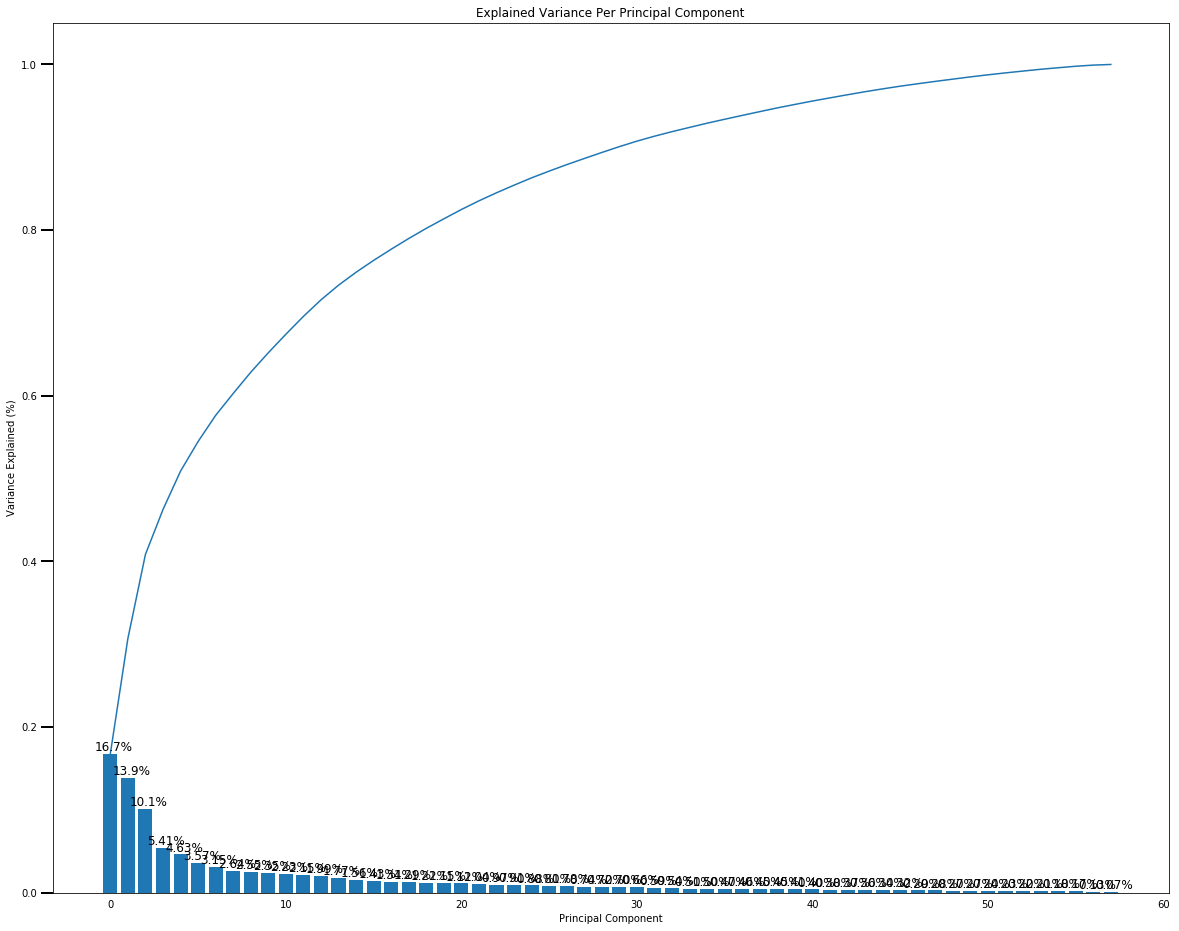

In [99]:
# Investigate the variance accounted for by each principal component.
# function to plot scree plot from Udacity helper functions file
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 16))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [100]:
#function for display and visualization of pca results from Udacity course helper functions file

def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
Dimension 1,0.1678,-0.1478,0.0074,-0.2325,0.1738,-0.1431,0.0909,0.1002,0.1537,0.0409,...,0.2185,0.0363,-0.1714,0.1505,0.1734,0.1429,0.1266,0.0823,0.2045,-0.1301
Dimension 2,0.1392,0.2530,0.0645,0.0538,-0.2343,0.2322,-0.2167,-0.2263,0.1349,-0.0562,...,0.1118,0.0130,-0.0956,0.0918,0.1061,0.0883,-0.2482,0.0232,0.0990,-0.0130
Dimension 3,0.1015,0.0474,-0.3625,0.1340,-0.0874,0.0701,-0.1775,-0.1027,-0.0461,-0.0175,...,0.0419,-0.0031,-0.0369,0.0304,0.0261,0.0262,-0.0657,-0.0304,0.0285,-0.0158
Dimension 4,0.0542,-0.0216,0.0031,0.0963,-0.0133,0.0047,-0.0987,0.0560,-0.1300,-0.0020,...,0.0627,0.0952,0.0060,0.0919,0.2597,0.1301,0.0311,-0.2788,-0.0998,0.0533
Dimension 5,0.0464,0.0261,0.0194,0.0198,0.0014,-0.0424,0.0862,-0.0874,-0.0174,-0.0060,...,0.1025,-0.3618,-0.3257,0.1184,-0.0851,0.0561,0.0336,0.1335,0.0986,-0.0555
Dimension 6,0.0358,0.0287,0.0057,-0.1054,0.0238,0.0379,0.0347,-0.0473,0.0711,0.0230,...,-0.0189,0.4148,0.2754,-0.1018,-0.0318,-0.0698,0.0358,0.1705,0.1544,-0.1386
Dimension 7,0.0316,0.0365,0.0496,-0.0719,-0.0096,-0.0356,-0.0195,-0.0425,0.1238,-0.1601,...,0.1858,0.0280,-0.0974,-0.2168,-0.2580,-0.2422,-0.0061,-0.0082,0.0074,-0.0275
Dimension 8,0.0265,-0.0495,-0.0169,-0.0917,0.0568,-0.1013,-0.0358,-0.0734,-0.0116,0.4412,...,-0.0030,-0.0520,-0.0275,-0.0453,-0.0254,-0.0440,0.1980,-0.0195,-0.0593,0.0396
Dimension 9,0.0256,-0.0680,0.1478,-0.0973,-0.1154,0.0135,-0.1320,-0.2472,0.1994,-0.2072,...,-0.1270,0.0594,0.1158,0.2942,0.0989,0.2000,-0.0114,0.0039,-0.0010,0.1623
Dimension 10,0.0236,-0.1582,0.0723,0.0288,-0.1689,0.2472,-0.2126,-0.1777,0.0466,0.1038,...,-0.0617,-0.2124,-0.1025,-0.3088,-0.0346,-0.1667,-0.1344,0.0873,-0.0102,-0.0440


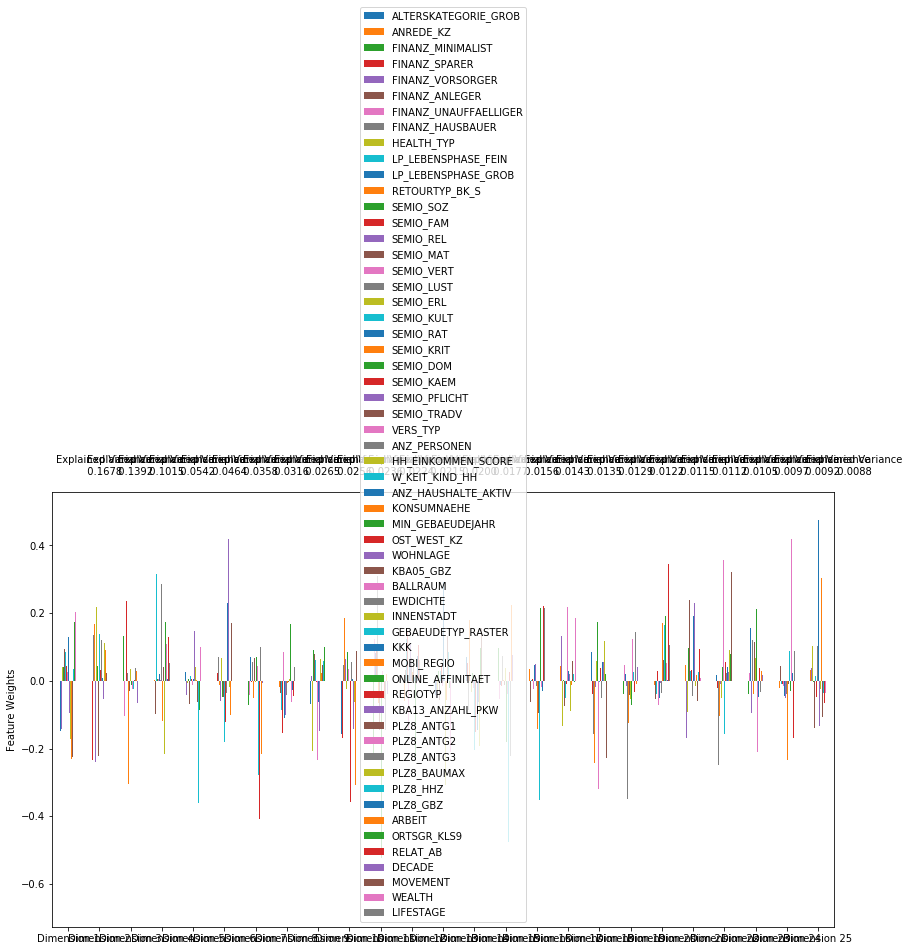

In [101]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca1 = PCA(n_components = 25)
X_pca1 = pca1.fit_transform(azdias_scaled)
pca_results(azdias_scaled, pca1)

In [102]:
#cumulative variance
display (pca1.explained_variance_ratio_.sum ())

0.86301704360305331

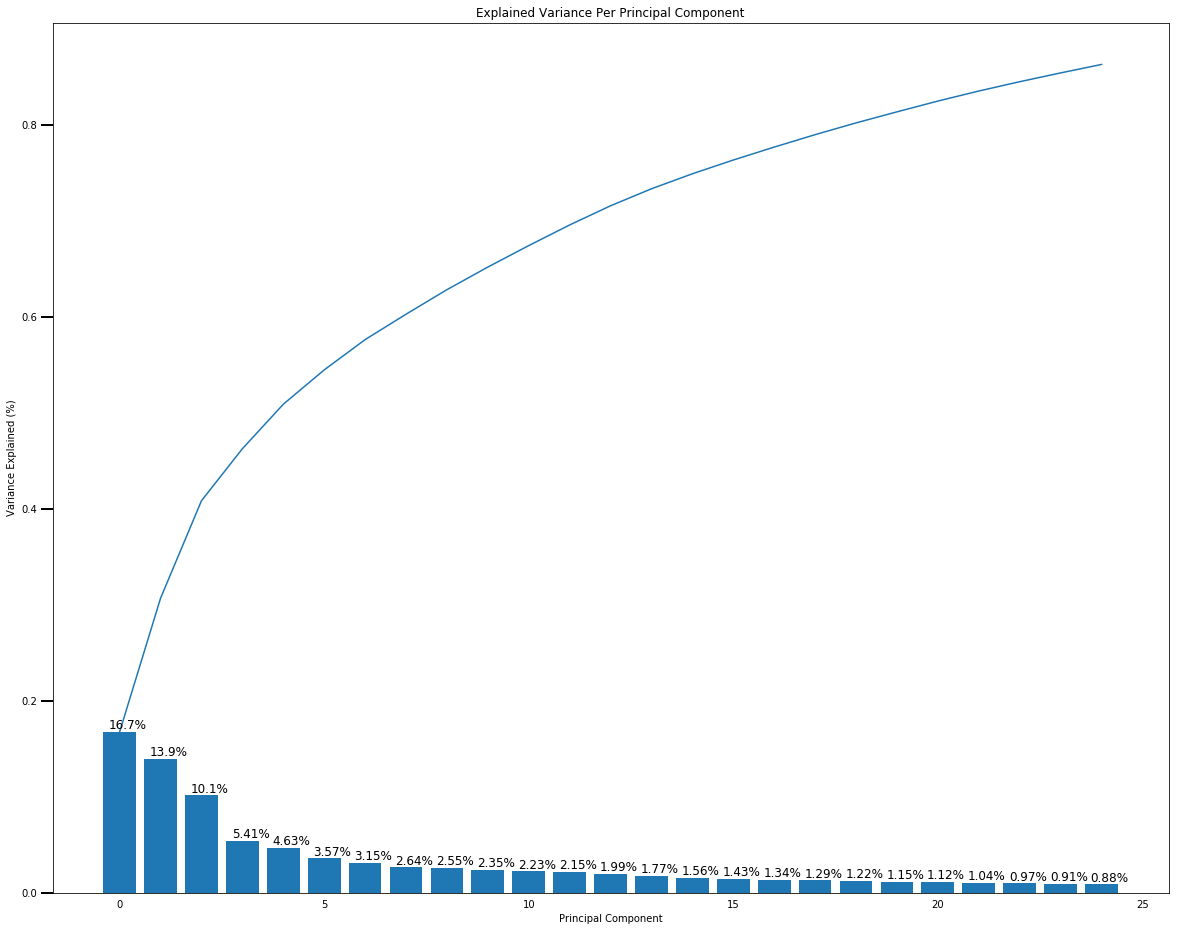

In [103]:
scree_plot(pca1)

### Discussion 2.2: Perform Dimensionality Reduction
Utilizing PCA I was able fit the dataset azdias_scaled to the model and create a scree plot of the full data set, where I observed that approximately 25 features would explain approximately 85% of the data variance.  25 features were selected and PCA was run again on the reduced data set.  Another plot was conducted whcih indicated the same conclusion as the original data plot indicating that these 25 features will explain approximately 86% of data variance.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [104]:
def pc_feat (item, df):
    sorted_df = df.sort_values(df.index [item], axis=1)
      
    return sorted_df.iloc [[item]]

In [105]:
pca1_comp = pd.DataFrame(pca1.components_, columns = column_list)
pca1_comp.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
0,-0.147795,0.007416,-0.232472,0.173847,-0.143071,0.090896,0.100173,0.153746,0.040866,-0.150286,...,0.218513,0.036269,-0.171408,0.150524,0.173428,0.142877,0.126611,0.082266,0.204507,-0.130083
1,0.253021,0.064460,0.053774,-0.234254,0.232197,-0.216695,-0.226274,0.134908,-0.056210,-0.059256,...,0.111803,0.012977,-0.095568,0.091812,0.106057,0.088261,-0.248227,0.023238,0.098987,-0.012963
2,0.047419,-0.362497,0.134004,-0.087418,0.070125,-0.177490,-0.102694,-0.046105,-0.017517,-0.002861,...,0.041909,-0.003104,-0.036898,0.030378,0.026090,0.026248,-0.065721,-0.030397,0.028478,-0.015793
3,-0.021593,0.003100,0.096283,-0.013303,0.004748,-0.098690,0.055970,-0.130021,-0.001962,0.315403,...,0.062653,0.095200,0.005987,0.091943,0.259708,0.130084,0.031125,-0.278778,-0.099763,0.053284
4,0.026104,0.019380,0.019835,0.001449,-0.042399,0.086241,-0.087408,-0.017367,-0.005990,0.268668,...,0.102452,-0.361750,-0.325697,0.118398,-0.085134,0.056137,0.033555,0.133450,0.098555,-0.055543


In [106]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pc_feat(0, pca1_comp)

,FINANZ_MINIMALIST,MOBI_REGIO,PLZ8_ANTG1,KBA05_GBZ,INNENSTADT,PLZ8_GBZ,KONSUMNAEHE,LP_LEBENSPHASE_GROB,LP_LEBENSPHASE_FEIN,ALTERSKATEGORIE_GROB,...,ARBEIT,FINANZ_HAUSBAUER,HH_EINKOMMEN_SCORE,PLZ8_ANTG2,ORTSGR_KLS9,FINANZ_SPARER,PLZ8_ANTG3,EWDICHTE,WEALTH,PLZ8_BAUMAX
0,-0.232472,-0.231431,-0.224176,-0.205014,-0.171979,-0.171408,-0.170268,-0.15039,-0.150286,-0.147795,...,0.150524,0.153746,0.17277,0.172796,0.173428,0.173847,0.200043,0.203408,0.204507,0.218513


In [107]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc_feat(1, pca1_comp)

,DECADE,SEMIO_REL,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,SEMIO_PFLICHT,SEMIO_TRADV,FINANZ_ANLEGER,SEMIO_KULT,SEMIO_RAT,SEMIO_FAM,...,ORTSGR_KLS9,PLZ8_BAUMAX,EWDICHTE,FINANZ_HAUSBAUER,W_KEIT_KIND_HH,RETOURTYP_BK_S,SEMIO_LUST,SEMIO_ERL,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB
1,-0.248227,-0.238915,-0.234254,-0.226274,-0.226057,-0.221884,-0.216695,-0.184852,-0.177887,-0.169698,...,0.106057,0.111803,0.121867,0.134908,0.138126,0.16873,0.175929,0.218022,0.232197,0.253021


In [108]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc_feat(2, pca1_comp)

,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_RAT,SEMIO_ERL,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,DECADE,...,SEMIO_REL,SEMIO_MAT,FINANZ_VORSORGER,W_KEIT_KIND_HH,RETOURTYP_BK_S,FINANZ_MINIMALIST,SEMIO_FAM,SEMIO_KULT,SEMIO_SOZ,SEMIO_VERT
2,-0.362497,-0.359794,-0.334569,-0.305994,-0.187252,-0.178092,-0.17749,-0.102694,-0.087418,-0.065721,...,0.055115,0.064999,0.070125,0.072843,0.08444,0.134004,0.235373,0.27924,0.289363,0.35338


### Discussion 2.3: Interpret Principal Components

Principal Component 1:	
Prominent negative features in ascending order are: FINANZ_MINIMALIST(low financial interest), MOBI_REGIO(movement patterns), PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region), KBA05_GBZ(Number of buildings in the microcell), INNENSTADT(Distance to city center (downtown)) The 5 most prodominant features indicate that these are the most likely to have substantial effect on the variation of this principal component 
Prominent Postive features in ascending order are: FINANZ_SPARER(money saver),	PLZ8_ANTG3(Number of 6-10 family houses in the PLZ8 region), EWDICHTE(Density of households per square kilometer), WEALTH, PLZ8_BAUMAX(Most common building type within the PLZ8 region) The 5 most prodominant features indicate that these are the most likely to have substantial effect on the variation of this principal component 
The lowest negaive component is -0.232 and highest postive component is 0.218, this would indicate that if the positive component rises the negative component will lessen by a slightly more rate as the two extremes are closely related.

Principaly Component 2:
Prominent negative features in ascending order are: DECADE,	SEMIO_REL(religious personality), FINANZ_SPARER(Financail - money saver), 	FINANZ_UNAUFFAELLIGER(Financail-inconspicuous), SEMIO_PFLICHT(dutiful personality)
Prominent Postive features in ascending order are: RETOURTYP_BK_S(Return type), SEMIO_LUST(personality-sensual-minded),	SEMIO_ERL(personlity-event-oriented), FINANZ_VORSORGER(financial-be prepared), ALTERSKATEGORIE_GROB(Estimated age based on given name analysis) The 5 most prodominant features indicate that these are the most likely to have substantial effect on the variation of this principal component 
The lowest negaive component is -0.248 and highest postive component is 0.253, this would indicate that if the positive component rises the negative component will lessen by a slightly less rate as the two extremes are closely related.

Principaly Component 3:
Prominent negative features in ascending order are: ANREDE_KZ(Gender), SEMIO_KAEM(personality-combative attitude), SEMIO_DOM(personality-dominant-minded), SEMIO_KRIT(personality-critical-minded), SEMIO_RAT(personality-rational)
Prominent Postive features in ascending order are: FINANZ_MINIMALIST(low financial interest), SEMIO_FAM(personality-family-minded),	SEMIO_KULT(personality-cultural-minded), SEMIO_SOZ(personality-socially-minded), SEMIO_VERT(personality-dreamful)
The 5 most prodominant features indicate that these are the most likely to have substantial effect on the variation of this principal component.  The lowest negative component is -0.362 and the highest positive component is 0.353, this would indicate that if the positive component rises the negative component will lessen by a slightly more rate as the two extremes are closely related.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [109]:
# function from Udacity given in helper functions
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score

In [110]:
# Over a number of different cluster counts...
scores = []
centers = list(range(1, 10))

for center in centers:
    scores.append(get_kmeans_score(X_pca1, center))

    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

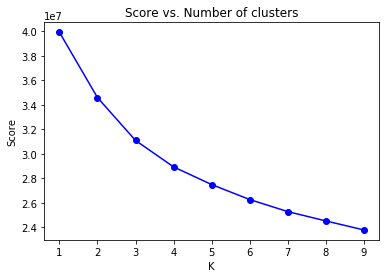

In [111]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='-', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Score');
plt.title('Score vs. Number of clusters');


In [112]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=4)
model = kmeans.fit(X_pca1)
X_pca1_cluster = model.predict(X_pca1)

In [113]:
X_pca1_cluster

array([3, 0, 3, ..., 0, 2, 3], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population
Upon observing the plot describing he Kmeans to the score the prominent elbow occurs at 4.  The data will be seperated into 4 clusters.  


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [114]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [115]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [116]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)


In [117]:
#customers_clean = pd.DataFrame(customers_clean, columns=column_list)
customers_clean.shape

(141714, 57)

In [128]:
len(customers_clean)

141714

In [118]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFESTAGE
0,2.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,1.953856,24.713863,...,1.554639,3.636689,3.624239,2.822951,4.776659,2.896636,2.789956,0.550197,2.597086,3.369529
1,3.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,3.000000,24.713863,...,1.000000,4.000000,3.000000,3.000000,7.000000,5.000000,2.789956,0.550197,3.000000,4.000000
2,4.0,1.0,5.0,1.0,4.0,1.0,1.0,3.0,2.000000,40.000000,...,1.000000,3.000000,3.000000,4.000000,4.776659,3.000000,2.000000,0.000000,2.000000,5.000000
3,4.0,1.0,4.0,1.0,5.0,1.0,3.0,5.0,2.000000,32.000000,...,3.000000,4.000000,3.000000,4.000000,8.000000,4.000000,3.000000,1.000000,4.000000,3.000000
4,3.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,3.000000,12.000000,...,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [119]:
# missing column from customers_clean
list(set(azdias.columns) - set(customers_clean))

['PLZ8_ANTG3']

In [133]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141714 entries, 0 to 141713
Data columns (total 57 columns):
ALTERSKATEGORIE_GROB     141714 non-null float64
ANREDE_KZ                141714 non-null float64
FINANZ_MINIMALIST        141714 non-null float64
FINANZ_SPARER            141714 non-null float64
FINANZ_VORSORGER         141714 non-null float64
FINANZ_ANLEGER           141714 non-null float64
FINANZ_UNAUFFAELLIGER    141714 non-null float64
FINANZ_HAUSBAUER         141714 non-null float64
HEALTH_TYP               141714 non-null float64
LP_LEBENSPHASE_FEIN      141714 non-null float64
LP_LEBENSPHASE_GROB      141714 non-null float64
RETOURTYP_BK_S           141714 non-null float64
SEMIO_SOZ                141714 non-null float64
SEMIO_FAM                141714 non-null float64
SEMIO_REL                141714 non-null float64
SEMIO_MAT                141714 non-null float64
SEMIO_VERT               141714 non-null float64
SEMIO_LUST               141714 non-null float64
SEMIO_E

In [137]:
customers_clean.isnull().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
VERS_TYP                 0
ANZ_PERSONEN             0
HH_EINKOMMEN_SCORE       0
W_KEIT_KIND_HH           0
ANZ_HAUSHALTE_AKTIV      0
KONSUMNAEHE              0
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
WOHNLAGE                 0
KBA05_GBZ                0
BALLRAUM                 0
E

In [139]:
scaler = StandardScaler()

In [140]:
customers_standard = scaler.transform(customers_clean)
pca_customers = pca.transform(customers_standard)
predict_customers = model_gen.predict(pca_customers)

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.